# Malaria Detection

## Import

In [1]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from my_ml_lib import DataManipulationTools, MetricTools, PlotTools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
pip install xgboost

You should consider upgrading via the 'c:\users\toorr\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [4]:
# Import different classifiers
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern, greycomatrix, greycoprops

## Functions

## Read dataset:

In [5]:
from numpy import asarray
path = './all-mias'
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for img_name in os.listdir(path):
        img_name = path+'/'+ img_name
        print(img_name)
        if img_name.endswith('.png'):
            img = cv2.imread(img_name)
            new_img = cv2.resize(img, (num2, num1))
            images.append(new_img)
#                     if file_name == 'Parasitized':
#                         label = 0
#                     else:
#                         label = 1
#                     labels.append(label)
    
    return np.array(images)#, np.array(labels)

## Save / Load Extracted Features:

In [58]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open( name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

## Save / Load Trained Model:

In [7]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

## Features:

### Histogram of oriented gradients (HOG) based Features:

In [8]:
# def get_hog(images, name='hog', save=False):
#     result = np.array([hog(img, block_norm='L2') for img in images])
    
#     if save:
#         save_feature(result, name)
        
#     return result

In [9]:
def get_hog(images, name='hog', save=False):
    # HOG Feature Extraction
    cell_size = (4, 4)    # h x w in pixels
    block_size = (2, 2)     # h x w in cells
    nbins = 9
    
    # winSize is the size of the image cropped to an multiple of the cell size
    # cell_size is the size of the cells of the img patch over which to calculate the histograms
    # block_size is the number of cells which fit in the patch
    hog_desc = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                              images[0].shape[0] // cell_size[0] * cell_size[0]),
                                    _blockSize=(block_size[1] * cell_size[1],
                                                block_size[0] * cell_size[0]),
                                    _blockStride=(cell_size[1], cell_size[0]),
                                    _cellSize=(cell_size[1], cell_size[0]),
                                    _nbins=nbins)
    
    def get_image_hog(image):
        # HOG feature 
        f = hog_desc.compute(image)
        
        res = np.array(f)
        return res.flatten()
    
    # HOG for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_hog(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

### Gabor based Features:

In [10]:
def get_gabor(images, name="gabor", save=False):
    
    # Gabor filter banks with different orientations and at different scales
    filters = []
    ksize = 9
    sigma = 0.1
    gamma = 0.5
    phi = 0
    
    # define the range for theta and nu
    for theta in np.arange(0, np.pi, np.pi / 8):
        for nu in np.arange(0, 6*np.pi/4, np.pi / 4):
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, nu, gamma, phi, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    
    # function to convolve the image with the filters
    def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum
        
    
    def get_image_gabor(image):
        # Local Binary Pattern
        f = []

        # calculating the local energy for each convolved image
        for j in range(40):
            res = process(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), filters[j])
            res = np.array(res)
            f.append(np.sum(np.multiply(res, res)))

        # calculating the mean amplitude for each convolved image
        for j in range(40):
            res = process(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), filters[j])
            res = np.array(res)
            f.append(np.sum(abs(res)))
        return f
    
    # Gabor descriptor for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_gabor(img)
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

### KAZE based features:

In [11]:
def get_kaze(images, name='kaze', save=False):
    
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        algo = cv2.KAZE_create()
        kps = algo.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = algo.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Scale-invariant feature transform (SIFT) based Features:

In [12]:
def get_sift(images, name='sift', save=False):
    
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result


In [13]:
def return_sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### Speeded-up robust features (SURF) based Features:

In [14]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [15]:
def return_surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

### Local-Binary-Pattern (LBP) based Features:

In [16]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

### Gray Level Co-occurrence Matrix (GLCM) based Features:

In [17]:
def get_glcm(images, name='glcm', save=False):
    
    # GLCM feature for 1 image
    def get_image_glcm(img):
        image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # GLCM Feature Extraction
        Grauwertmatrix = greycomatrix(image, [1, 2, 3], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
                                                  symmetric=False, normed=True)
        
        contrast = greycoprops(Grauwertmatrix, 'contrast')
        dissimilarity = greycoprops(Grauwertmatrix, 'dissimilarity')
        homogeneity = greycoprops(Grauwertmatrix, 'homogeneity')
        energy = greycoprops(Grauwertmatrix, 'energy')
        correlation = greycoprops(Grauwertmatrix, 'correlation')
        ASM = greycoprops(Grauwertmatrix, 'ASM')
        
        # Merge all the features
        f = np.array([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
        return f.flatten()
    
    
    # GLCM descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_glcm(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Flattened Image:

In [18]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

### Color Histograms:

In [19]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

### Combine Features:

In [20]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

### Normalize features:

In [21]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [22]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

## Classifiers:

In [23]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['NB', 'SVM', 'XGB', 'MLP', 'ADA', 'BAG', 'RF']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

### ROC

In [24]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [198]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

### CM

In [26]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

### PCA projected data

In [27]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,30))
    for i, img in enumerate(mat, start=1):
        plt.subplot(5, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

In [28]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

## Main cells

## Read and split data

### Read and Store

In [29]:
from numpy import asarray
path = './all-mias'
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for img_name in os.listdir(path):
        img_name = path+'/'+ img_name
        print(img_name)
        if img_name.endswith('.pgm'):
            img = cv2.imread(img_name)
            new_img = cv2.resize(img, (num2, num1))
            images.append(new_img)
#                     if file_name == 'Parasitized':
#                         label = 0
#                     else:
#                         label = 1
#                     labels.append(label)
    
    return np.array(images)#, np.array(labels)

In [30]:
full_data_x = read_images(path)

./all-mias/Info.txt
./all-mias/Licence.txt
./all-mias/mdb001.pgm
./all-mias/mdb002.pgm
./all-mias/mdb003.pgm
./all-mias/mdb004.pgm
./all-mias/mdb005.pgm
./all-mias/mdb006.pgm
./all-mias/mdb007.pgm
./all-mias/mdb008.pgm
./all-mias/mdb009.pgm
./all-mias/mdb010.pgm
./all-mias/mdb011.pgm
./all-mias/mdb012.pgm
./all-mias/mdb013.pgm
./all-mias/mdb014.pgm
./all-mias/mdb015.pgm
./all-mias/mdb016.pgm
./all-mias/mdb017.pgm
./all-mias/mdb018.pgm
./all-mias/mdb019.pgm
./all-mias/mdb020.pgm
./all-mias/mdb021.pgm
./all-mias/mdb022.pgm
./all-mias/mdb023.pgm
./all-mias/mdb024.pgm
./all-mias/mdb025.pgm
./all-mias/mdb026.pgm
./all-mias/mdb027.pgm
./all-mias/mdb028.pgm
./all-mias/mdb029.pgm
./all-mias/mdb030.pgm
./all-mias/mdb031.pgm
./all-mias/mdb032.pgm
./all-mias/mdb033.pgm
./all-mias/mdb034.pgm
./all-mias/mdb035.pgm
./all-mias/mdb036.pgm
./all-mias/mdb037.pgm
./all-mias/mdb038.pgm
./all-mias/mdb039.pgm
./all-mias/mdb040.pgm
./all-mias/mdb041.pgm
./all-mias/mdb042.pgm
./all-mias/mdb043.pgm
./all-mias/

In [444]:
from csv import reader
dict={'B':1,'M':1}

label=[]
with open('Info.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
       # print(row)
        if(row[0].split(" ")[2]=="NORM"):
            label.append(0)
        else:
            label.append(dict[row[0].split(" ")[3]])
full_data_y=np.array(label[:322])

In [228]:
print("dataset size : ", len(full_data_x), len(full_data_y))

dataset size :  322 322


In [229]:
print("One Image size: ", full_data_x[2].shape)

One Image size:  (32, 32, 3)


In [230]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [231]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)

In [232]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape) 
print("Test data :", test_x.shape, "         Label: ", test_y.shape) 

Train data : (205, 32, 32, 3)        Label:  (205,)
Validation data : (52, 32, 32, 3)    Label:  (52,)
Test data : (65, 32, 32, 3)          Label:  (65,)


### Save train, validation, test data

In [233]:
np.save('train_imgs.npy', train_imgs)
np.save('train_y.npy', train_y)
np.save('val_imgs.npy', val_imgs)
np.save('val_y.npy', val_y)
np.save('data_x.npy', data_x)
np.save('data_y.npy', data_y)
np.save('test_x.npy', test_x)
np.save('test_y.npy', test_y)

### Load 

In [234]:
train_imgs = np.load('train_imgs.npy')
train_y = np.load('train_y.npy')
val_imgs = np.load('val_imgs.npy')
val_y = np.load('val_y.npy')

data_x = np.load('data_x.npy')
data_y = np.load('data_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [235]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((257, 32, 32, 3), (65, 32, 32, 3), (257,), (65,))

In [236]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((205, 32, 32, 3), (52, 32, 32, 3), (205,), (52,))

## Training

### Training & Validation set features:


#### Data visualization:

In [237]:
infected_img = train_imgs[train_y == 0][0]
uninfected_img = train_imgs[train_y == 1][0]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [239]:
hog_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
#sift = np.zeros((2, 32, 32, 3), dtype='uint8')
#surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, hog_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    #sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_sift_kp(classes[i]))
    #surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_surf_kp(classes[i]))

In [240]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(hog_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
for i in range(len(classes)):
    data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
for i in range(len(classes)):
    img_name_arr.append('SURF')

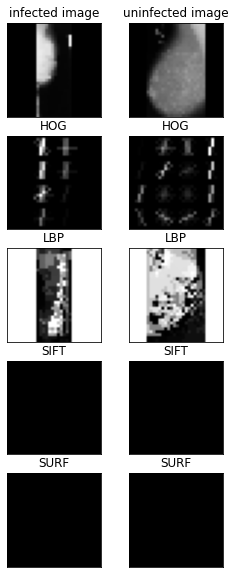

In [241]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()


### HOG features:

In [242]:
def get_hog(images, name='hog', save=False):
    # HOG Feature Extraction
    cell_size = (4, 4)    # h x w in pixels
    block_size = (2, 2)     # h x w in cells
    nbins = 9
    
    # winSize is the size of the image cropped to an multiple of the cell size
    # cell_size is the size of the cells of the img patch over which to calculate the histograms
    # block_size is the number of cells which fit in the patch
    hog_desc = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                              images[0].shape[0] // cell_size[0] * cell_size[0]),
                                    _blockSize=(block_size[1] * cell_size[1],
                                                block_size[0] * cell_size[0]),
                                    _blockStride=(cell_size[1], cell_size[0]),
                                    _cellSize=(cell_size[1], cell_size[0]),
                                    _nbins=nbins)
    
    def get_image_hog(image):
        # HOG feature 
        f = hog_desc.compute(image)
        
        res = np.array(f)
        return res.flatten()
    
    # HOG for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_hog(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

In [243]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [244]:
hog_train = load_feature('hog_train.pkl')
hog_val = load_feature('hog_val.pkl')

In [245]:
hog_train.shape, hog_val.shape

((205, 1764), (52, 1764))

### LBP features:

In [246]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [247]:
lbp_train = load_feature('lbp_train.pkl')
lbp_val = load_feature('lbp_val.pkl')

In [248]:
lbp_train.shape, lbp_val.shape

((205, 1024), (52, 1024))

### KAZE Features:

In [249]:
kaze_train = get_kaze(train_imgs, name='kaze_train', save=True)
kaze_val = get_kaze(val_imgs, name='kaze_val', save=True)

Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [250]:
kaze_train = load_feature('kaze_train.pkl')
kaze_val = load_feature('kaze_val.pkl')

In [251]:
kaze_train.shape, kaze_val.shape

((205, 2048), (52, 2048))

### SIFT Features:

In [252]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [ ]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [ ]:
sift_train.shape, sift_val.shape

### SURF Features:

In [253]:
surf_train = get_surf(train_imgs, name='surf_train', save=True)
surf_val = get_surf(val_imgs, name='surf_val', save=True)

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [254]:
surf_train = load_feature('cache/surf_train.pkl')
surf_val = load_feature('cache/surf_val.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'cache/surf_train.pkl'

In [255]:
surf_train.shape, surf_val.shape

NameError: name 'surf_train' is not defined

### Gabor Features:

In [256]:
gabor_train = get_gabor(train_imgs, name='gabor_train', save=True)
gabor_val = get_gabor(val_imgs, name='gabor_val', save=True)

Feature saved with name cache/gabor_train.pkl
Feature saved with name cache/gabor_val.pkl


In [257]:
gabor_train = load_feature('gabor_train.pkl')
gabor_val = load_feature('gabor_val.pkl')

In [258]:
gabor_train.shape, gabor_val.shape

((205, 80), (52, 80))

### GLCM Features:

In [259]:
glcm_train = get_glcm(train_imgs, name='glcm_train', save=True)
glcm_val = get_glcm(val_imgs, name='glcm_val', save=True)

Feature saved with name cache/glcm_train.pkl
Feature saved with name cache/glcm_val.pkl


In [260]:
glcm_train = load_feature('glcm_train.pkl')
glcm_val = load_feature('glcm_val.pkl')

In [261]:
glcm_train.shape, glcm_val.shape

((205, 72), (52, 72))

### Flattened Image

#### RGB:

In [262]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [263]:
flat_rgb_train = load_feature('flat_rgb_train.pkl')
flat_rgb_val = load_feature('flat_rgb_val.pkl')

In [264]:
flat_rgb_train.shape, flat_rgb_val.shape

((205, 3072), (52, 3072))

#### GRAY:

In [265]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [266]:
flat_gray_train = load_feature('flat_gray_train.pkl')
flat_gray_val = load_feature('flat_gray_val.pkl')

In [267]:
flat_gray_train.shape, flat_gray_val.shape

((205, 1024), (52, 1024))

#### Color Histogram:

In [268]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [269]:
hist_train = load_feature('hist_train.pkl')
hist_val = load_feature('hist_val.pkl')

In [270]:
hist_train.shape, hist_val.shape

((205, 512), (52, 512))

### Reduce Features by PCA:

#### HOG Features:

In [271]:
# norm_hog_train, norm_hog_val = norm_features_minmax(hog_train, hog_val)
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [272]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [273]:
np.save('pca_hog_train.npy', pca_hog_train)
np.save('pca_hog_val.npy', pca_hog_val)

In [274]:
pca_hog_train = np.load('pca_hog_train.npy')
pca_hog_val = np.load('pca_hog_val.npy')

In [275]:
pca_hog_train.shape, pca_hog_val.shape

((205, 10), (52, 10))

#### LBP Features:

In [276]:
# norm_lbp_train, norm_lbp_val = norm_features_minmax(lbp_train, lbp_val)
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [277]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [278]:
np.save('pca_lbp_train.npy', pca_lbp_train)
np.save('pca_lbp_val.npy', pca_lbp_val)

In [279]:
pca_lbp_train = np.load('pca_lbp_train.npy')
pca_lbp_val = np.load('pca_lbp_val.npy')

In [280]:
pca_lbp_train.shape, pca_lbp_val.shape

((205, 10), (52, 10))

#### KAZE Features:

In [281]:
# norm_kaze_train, norm_kaze_val = norm_features_minmax(kaze_train, kaze_val)
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

In [282]:
pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

In [283]:
np.save('pca_kaze_train.npy', pca_kaze_train)
np.save('pca_kaze_val.npy', pca_kaze_val)

In [284]:
pca_kaze_train = np.load('pca_kaze_train.npy')
pca_kaze_val = np.load('pca_kaze_val.npy')

In [285]:
pca_kaze_train.shape, pca_kaze_val.shape

((205, 10), (52, 10))

#### SIFT Features:

In [286]:
# norm_sift_train, norm_sift_val = norm_features_minmax(sift_train, sift_val)
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

NameError: name 'sift_train' is not defined

In [287]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

NameError: name 'norm_sift_train' is not defined

In [288]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

NameError: name 'pca_sift_train' is not defined

In [289]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'cache/pca_sift_train.npy'

In [290]:
pca_sift_train.shape, pca_sift_val.shape

NameError: name 'pca_sift_train' is not defined

#### SURF Features:

In [291]:
# norm_surf_train, norm_surf_val = norm_features_minmax(surf_train, surf_val)
norm_surf_train, norm_surf_val = norm_features_zscore(surf_train, surf_val)

NameError: name 'surf_train' is not defined

In [292]:
pca = PCA(n_components=5)
pca_surf_train = pca.fit_transform(norm_surf_train)
pca_surf_val = pca.transform(norm_surf_val)

NameError: name 'norm_surf_train' is not defined

In [293]:
np.save('cache/pca_surf_train.npy', pca_surf_train)
np.save('cache/pca_surf_val.npy', pca_surf_val)

NameError: name 'pca_surf_train' is not defined

In [294]:
pca_surf_train = np.load('cache/pca_surf_train.npy')
pca_surf_val = np.load('cache/pca_surf_val.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'cache/pca_surf_train.npy'

In [295]:
pca_surf_train.shape, pca_surf_val.shape

NameError: name 'pca_surf_train' is not defined

#### Gabor Fearures:

In [296]:
# norm_gabor_train, norm_gabor_val = norm_features_minmax(gabor_train, gabor_val)
norm_gabor_train, norm_gabor_val = norm_features_zscore(gabor_train, gabor_val)

In [297]:
pca = PCA(n_components=5)
pca_gabor_train = pca.fit_transform(norm_gabor_train)
pca_gabor_val = pca.transform(norm_gabor_val)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [298]:
np.save('pca_gabor_train.npy', pca_gabor_train)
np.save('pca_gabor_val.npy', pca_gabor_val)

In [299]:
pca_gabor_train = np.load('pca_gabor_train.npy')
pca_gabor_val = np.load('pca_gabor_val.npy')

In [300]:
pca_gabor_train.shape, pca_gabor_val.shape

((205, 5), (52, 5))

#### GLCM Features:

In [301]:
# norm_glcm_train, norm_glcm_val = norm_features_minmax(glcm_train, glcm_val)
norm_glcm_train, norm_glcm_val = norm_features_zscore(glcm_train, glcm_val)

In [302]:
pca = PCA(n_components=5)
pca_glcm_train = pca.fit_transform(norm_glcm_train)
pca_glcm_val = pca.transform(norm_glcm_val)

In [303]:
np.save('pca_glcm_train.npy', pca_glcm_train)
np.save('pca_glcm_val.npy', pca_glcm_val)

In [304]:
pca_glcm_train = np.load('pca_glcm_train.npy')
pca_glcm_val = np.load('pca_glcm_val.npy')

In [305]:
pca_glcm_train.shape, pca_glcm_val.shape

((205, 5), (52, 5))

#### Flattened Image:

#### RGB:

In [306]:
# norm_flat_rgb_train, norm_flat_rgb_val = norm_features_minmax(flat_rgb_train, flat_rgb_val)
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

In [307]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [308]:
np.save('pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [309]:
pca_flat_rgb_train = np.load('pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('pca_flat_rgb_val.npy')

In [310]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((205, 10), (52, 10))

#### GRAY:

In [311]:
# norm_flat_gray_train, norm_flat_gray_val = norm_features_minmax(flat_gray_train, flat_gray_val)
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

In [312]:
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [313]:
np.save('pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('pca_flat_gray_val.npy', pca_flat_gray_val)

In [314]:
pca_flat_gray_train = np.load('pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('pca_flat_gray_val.npy')

In [315]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((205, 6), (52, 6))

#### Color Histogram:

In [316]:
# norm_hist_train, norm_hist_val = norm_features_minmax(hist_train, hist_val)
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [317]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [318]:
np.save('pca_hist_train.npy', pca_hist_train)
np.save('pca_hist_val.npy', pca_hist_val)

In [319]:
pca_hist_train = np.load('pca_hist_train.npy')
pca_hist_val = np.load('pca_hist_val.npy')

In [320]:
pca_hist_train.shape, pca_hist_val.shape

((205, 10), (52, 10))

### Feature PCA variance comparison:

In [321]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
# pca_array.append(pca_sift_train)
# pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_gabor_train)
pca_array.append(pca_glcm_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)
len(pca_array)

8

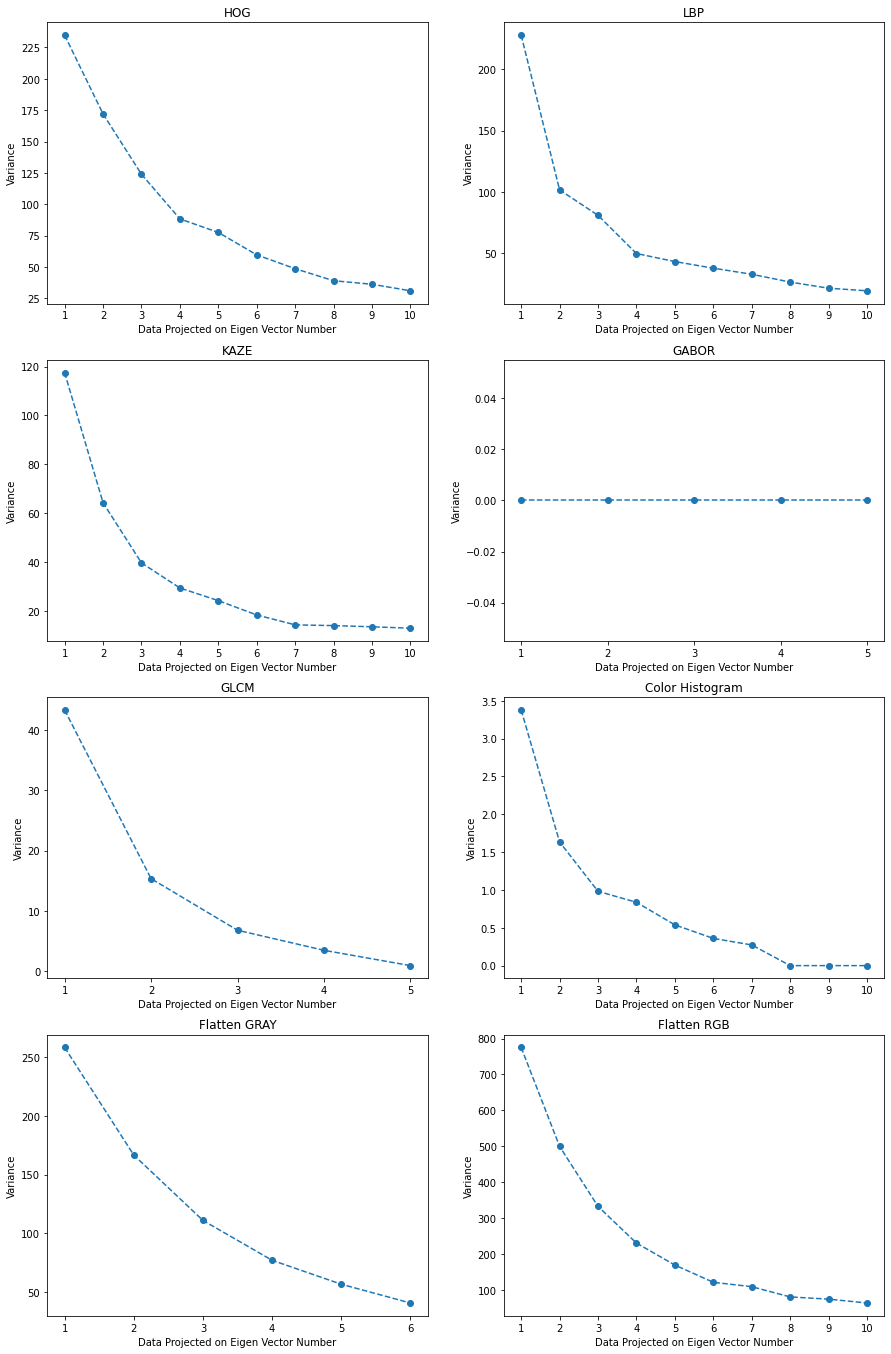

In [322]:
pca_projection(pca_array, ['HOG', 'LBP', 'KAZE', 'GABOR', 'GLCM', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

### Reduce Features by LDA:

#### HOG Features:

In [323]:
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)

In [324]:
lda_hog_train.shape, lda_hog_val.shape

((205, 1), (52, 1))

In [325]:
np.save('lda_hog_train.npy', lda_hog_train)
np.save('lda_hog_val.npy', lda_hog_val)

In [326]:
lda_hog_train = np.load('lda_hog_train.npy')
lda_hog_val = np.load('lda_hog_val.npy')

In [327]:
lda_hog_train.shape, lda_hog_val.shape

((205, 1), (52, 1))

#### LBP Features:

In [328]:
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)

In [329]:
np.save('lda_lbp_train.npy', lda_lbp_train)
np.save('lda_lbp_val.npy', lda_lbp_val)

In [330]:
lda_lbp_train = np.load('lda_lbp_train.npy')
lda_lbp_val = np.load('lda_lbp_val.npy')

In [331]:
lda_lbp_train.shape, lda_lbp_val.shape

((205, 1), (52, 1))

#### SIFT:

In [332]:
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)

NameError: name 'norm_sift_train' is not defined

In [333]:
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)

NameError: name 'lda_sift_train' is not defined

In [334]:
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'cache/lda_sift_train.npy'

In [335]:
lda_sift_train.shape, lda_sift_val.shape

NameError: name 'lda_sift_train' is not defined

#### Color Histogram:

In [336]:
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)

In [337]:
np.save('lda_hist_train.npy', lda_hist_train)
np.save('lda_hist_val.npy', lda_hist_val)

In [338]:
lda_hist_train = np.load('lda_hist_train.npy')
lda_hist_val = np.load('lda_hist_val.npy')

In [339]:
lda_hist_train.shape, lda_hist_val.shape

((205, 1), (52, 1))

### Combine Features normal:

In [340]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train,  flat_rgb_train, lbp_train, kaze_train,  gabor_train, glcm_train], 
                  [hog_val, hist_val,  flat_rgb_val, lbp_val, kaze_val, gabor_val, glcm_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [341]:
features_train.shape, features_val.shape

((205, 8572), (52, 8572))

### Combine Features PCA:

In [342]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train,  pca_flat_rgb_train, pca_hist_train, pca_glcm_train], 
                  [pca_hog_val, pca_lbp_val,  pca_flat_rgb_val, pca_hist_val, pca_glcm_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [343]:
features_train.shape, features_val.shape

((205, 45), (52, 45))

### Combine Features LDA:

In [344]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [345]:
features_train_lda.shape, features_val_lda.shape

((205, 3), (52, 3))

### LDA on PCA

In [346]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

In [347]:
np.save('lda_on_pca_train.npy', lda_on_pca_train)
np.save('lda_on_pca_val.npy', lda_on_pca_val)

In [348]:
lda_on_pca_train = np.load('lda_on_pca_train.npy')
lda_on_pca_val = np.load('lda_on_pca_val.npy')

In [349]:
lda_on_pca_train.shape, lda_on_pca_val.shape

((205, 1), (52, 1))

### Combine Features:

In [350]:
features_t = pca_hist_train
features_v = pca_hist_val

In [351]:
features_t.shape, features_v.shape

((205, 10), (52, 10))

## Classification:

### PCA

In [352]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.5769230769230769
[[28  5]
 [17  2]]
Recall in 'RF' = 0.8484848484848485
Precision in 'RF' = 0.6222222222222222
F1 Score in 'RF' = 0.7179487179487178


In [353]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [354]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.5769230769230769
[[27  6]
 [16  3]]
Recall in 'BAG' = 0.8181818181818182
Precision in 'BAG' = 0.627906976744186
F1 Score in 'BAG' = 0.7105263157894738


In [355]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [356]:
model3 = train_model(features_train, train_y, model_name='ADA', validation=(features_val, val_y))

Validation Accuracy in 'ADA' = 0.5961538461538461
[[23 10]
 [11  8]]
Recall in 'ADA' = 0.696969696969697
Precision in 'ADA' = 0.6764705882352942
F1 Score in 'ADA' = 0.6865671641791046


In [357]:
prob3 = model3.predict_proba(features_val)
prob30 = prob3[:,0].reshape(prob3.shape[0], 1)
prob31 = prob3[:,1].reshape(prob3.shape[0], 1)

In [358]:
model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6153846153846154
[[27  6]
 [14  5]]
Recall in 'NB' = 0.8181818181818182
Precision in 'NB' = 0.6585365853658537
F1 Score in 'NB' = 0.7297297297297297


In [359]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [360]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.5961538461538461
[[30  3]
 [18  1]]
Recall in 'SVM' = 0.9090909090909091
Precision in 'SVM' = 0.625
F1 Score in 'SVM' = 0.7407407407407406


In [361]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [362]:
model6 = train_model(np.array(features_train), train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.5769230769230769
[[24  9]
 [13  6]]
Recall in 'XGB' = 0.7272727272727273
Precision in 'XGB' = 0.6486486486486487
F1 Score in 'XGB' = 0.6857142857142857


In [363]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [364]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.5576923076923077
[[22 11]
 [12  7]]
Recall in 'KNN' = 0.6666666666666666
Precision in 'KNN' = 0.6470588235294118
F1 Score in 'KNN' = 0.6567164179104478


In [365]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

In [468]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
#         for j in range(len(prob[:,i])):
#             if prob[j][i]<0.3:
#                 prob[j][i]=0
#             else:
#                 prob[j][i]=1
        print("prob: ",test_y,prob[:,i])
        
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i],pos_label=2)
        print(fpr[i],tpr[i],"va;ues")
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

In [469]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    print(fpr,tpr)
    plt.plot("this",fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

prob:  [1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0] [0.54602396 0.49904512 0.64776581 0.46595411 0.45194813 0.46674848
 0.53021722 0.46595411 0.57967232 0.47638271 0.51506306 0.57121902
 0.50096564 0.47105609 0.53135514 0.55750627 0.47022861 0.5367666
 0.42360267 0.52123644 0.50992535 0.4792213  0.51491193 0.51235832
 0.50476118 0.43053746 0.54731906 0.48230383 0.44647499 0.47391467
 0.6131034  0.37689661 0.55750627 0.53857701 0.54532567 0.53563033
 0.41090047 0.49543551 0.36674486 0.45194813 0.55750627 0.56750072
 0.55499215 0.3449004  0.51306574 0.38318493 0.53280046 0.55376194
 0.50992535 0.50096564 0.54602396 0.56714321]
[0.         0.01923077 0.11538462 0.17307692 0.23076923 0.26923077
 0.5        0.53846154 0.55769231 0.59615385 0.76923077 0.84615385
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
prob:  [1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 0 

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

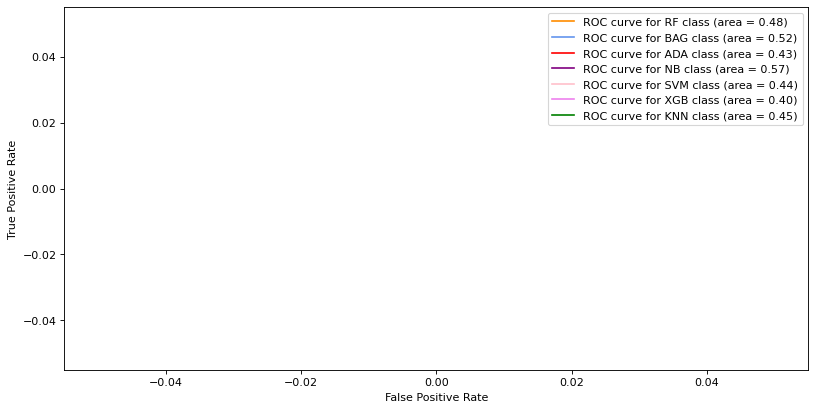

In [470]:
prob = np.concatenate((prob10, prob20, prob30, prob40, prob50, prob60, prob70), axis=1)
plot_combine_roc(val_y, prob)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 0.07692308 0.15384615 0.19230769 0.25
 0.28846154 0.38461538 0.44230769 0.51923077 0.63461538 0.71153846
 0.73076923 0.76923077 0.86538462 0.90384615 0.92307692 0.96153846
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.03846154 0.96153846 1.        ] [nan nan nan nan] va;ues


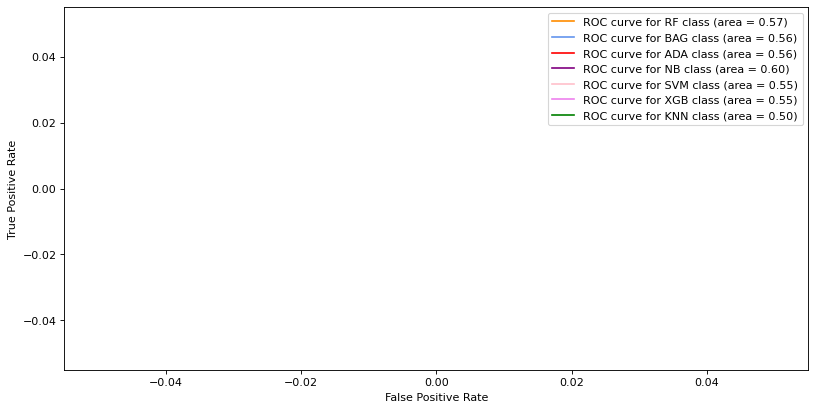

In [377]:
prob = np.concatenate((prob11, prob21, prob31, prob41, prob51, prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

### LDA

In [378]:
model8 = train_model(features_train_lda, train_y, model_name='RF', validation=(features_val_lda, val_y))

Validation Accuracy in 'RF' = 0.5576923076923077
[[23 10]
 [13  6]]
Recall in 'RF' = 0.696969696969697
Precision in 'RF' = 0.6388888888888888
F1 Score in 'RF' = 0.6666666666666666


In [379]:
prob8 = model8.predict_proba(features_val_lda)
prob80 = prob8[:,0].reshape(prob8.shape[0], 1)
prob81 = prob8[:,1].reshape(prob8.shape[0], 1)

In [380]:
model9 = train_model(features_train_lda, train_y, model_name='BAG', validation=(features_val_lda, val_y))

Validation Accuracy in 'BAG' = 0.5384615384615384
[[21 12]
 [12  7]]
Recall in 'BAG' = 0.6363636363636364
Precision in 'BAG' = 0.6363636363636364
F1 Score in 'BAG' = 0.6363636363636364


In [381]:
prob9 = model9.predict_proba(features_val_lda)
prob90 = prob9[:,0].reshape(prob9.shape[0], 1)
prob91 = prob9[:,1].reshape(prob9.shape[0], 1)

In [382]:
model10 = train_model(features_train_lda, train_y, model_name='ADA', validation=(features_val_lda, val_y))

Validation Accuracy in 'ADA' = 0.5384615384615384
[[20 13]
 [11  8]]
Recall in 'ADA' = 0.6060606060606061
Precision in 'ADA' = 0.6451612903225806
F1 Score in 'ADA' = 0.625


In [383]:
prob10 = model10.predict_proba(features_val_lda)
prob100 = prob10[:,0].reshape(prob10.shape[0], 1)
prob101 = prob10[:,1].reshape(prob10.shape[0], 1)

In [384]:
model11 = train_model(features_train_lda, train_y, model_name='NB', validation=(features_val_lda, val_y))

Validation Accuracy in 'NB' = 0.5
[[20 13]
 [13  6]]
Recall in 'NB' = 0.6060606060606061
Precision in 'NB' = 0.6060606060606061
F1 Score in 'NB' = 0.6060606060606061


In [385]:
prob11 = model11.predict_proba(features_val_lda)
prob110 = prob11[:,0].reshape(prob11.shape[0], 1)
prob111 = prob11[:,1].reshape(prob11.shape[0], 1)

In [386]:
model12 = train_model(features_train_lda, train_y, model_name='SVM', validation=(features_val_lda, val_y))

Validation Accuracy in 'SVM' = 0.5192307692307693
[[20 13]
 [12  7]]
Recall in 'SVM' = 0.6060606060606061
Precision in 'SVM' = 0.625
F1 Score in 'SVM' = 0.6153846153846154


In [387]:
prob12 = model12.predict_proba(features_val_lda)
prob120 = prob12[:,0].reshape(prob12.shape[0], 1)
prob121 = prob12[:,1].reshape(prob12.shape[0], 1)

In [388]:
model13 = train_model(features_train_lda, train_y, model_name='XGB', validation=(features_val_lda, val_y))

Validation Accuracy in 'XGB' = 0.5961538461538461
[[24  9]
 [12  7]]
Recall in 'XGB' = 0.7272727272727273
Precision in 'XGB' = 0.6666666666666666
F1 Score in 'XGB' = 0.6956521739130435


In [389]:
prob13 = model13.predict_proba(features_val_lda)
prob130 = prob13[:,0].reshape(prob13.shape[0], 1)
prob131 = prob13[:,1].reshape(prob13.shape[0], 1)

In [390]:
model14 = train_model(features_train_lda, train_y, model_name='KNN', validation=(features_val_lda, val_y))

Validation Accuracy in 'KNN' = 0.4807692307692308
[[20 13]
 [14  5]]
Recall in 'KNN' = 0.6060606060606061
Precision in 'KNN' = 0.5882352941176471
F1 Score in 'KNN' = 0.5970149253731343


In [391]:
prob14 = model14.predict_proba(features_val_lda)
prob140 = prob14[:,0].reshape(prob14.shape[0], 1)
prob141 = prob14[:,1].reshape(prob14.shape[0], 1)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

[0.         0.01923077 0.05769231 0.09615385 0.80769231 0.84615385
 1.        ] [nan nan nan nan nan nan nan] va;ues
[0.         0.19230769 0.26923077 0.34615385 0.38461538 0.48076923
 0.51923077 0.55769231 0.61538462 0.67307692 0.71153846 0.78846154
 0.84615385 0.90384615 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 0.11538462 0.17307692 0.23076923 0.26923077
 0.5        0.53846154 0.55769231 0.59615385 0.76923077 0.84615385
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 0.17307692 0.21153846 0.73076923 0.76923077
 1.        ] [nan nan nan nan nan nan nan] va;ues
[0.         0.30769231 0.86538462 1.        ] [nan nan nan nan] va;ues


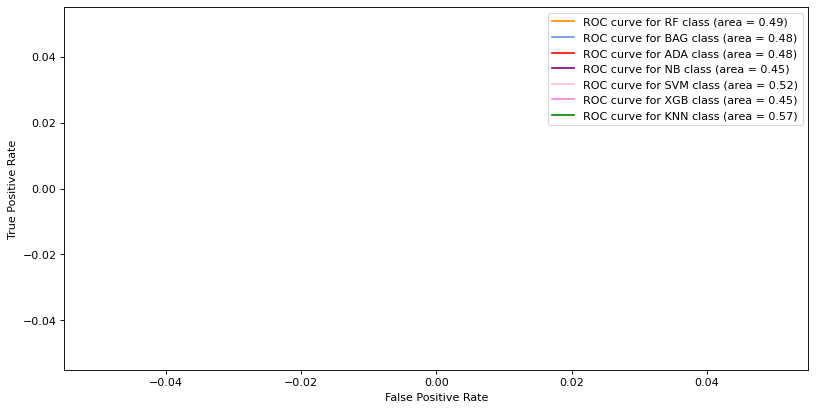

In [392]:
prob = np.concatenate((prob80, prob90, prob100, prob110, prob120, prob130, prob140), axis=1)
plot_combine_roc(val_y, prob)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

[0.         0.01923077 0.15384615 0.19230769 0.90384615 0.94230769
 1.        ] [nan nan nan nan nan nan nan] va;ues
[0.         0.09615385 0.15384615 0.21153846 0.28846154 0.32692308
 0.38461538 0.44230769 0.48076923 0.51923077 0.61538462 0.65384615
 0.73076923 0.80769231 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 0.15384615 0.23076923 0.40384615 0.44230769
 0.46153846 0.5        0.73076923 0.76923077 0.82692308 0.88461538
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 0.23076923 0.26923077 0.78846154 0.82692308
 1.        ] [nan nan nan nan nan nan nan] va;ues
[0.         0.13461538 0.69230769 1.        ] [nan nan nan nan] va;ues


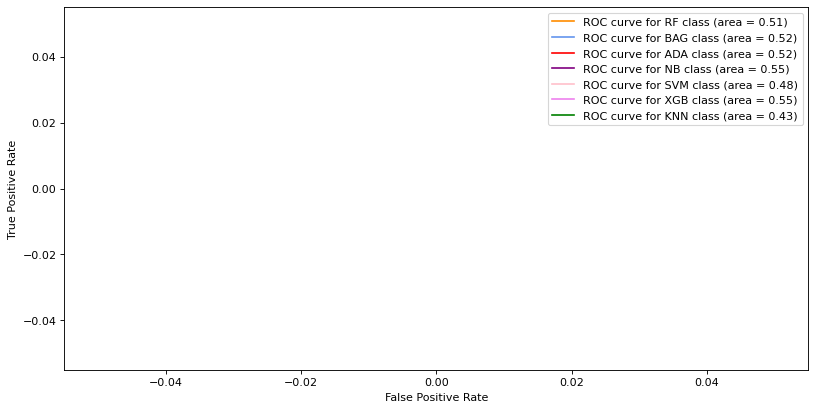

In [393]:
prob = np.concatenate((prob81, prob91, prob101, prob111, prob121, prob131, prob141), axis=1)
plot_combine_roc(val_y, prob)

### LDA on PCA

In [394]:
model15 = train_model(lda_on_pca_train, train_y, model_name='RF', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'RF' = 0.5576923076923077
[[21 12]
 [11  8]]
Recall in 'RF' = 0.6363636363636364
Precision in 'RF' = 0.65625
F1 Score in 'RF' = 0.6461538461538462


In [395]:
prob15 = model15.predict_proba(lda_on_pca_val)
prob150 = prob15[:,0].reshape(prob15.shape[0], 1)
prob151 = prob15[:,1].reshape(prob15.shape[0], 1)

In [396]:
model16 = train_model(lda_on_pca_train, train_y, model_name='BAG', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'BAG' = 0.5769230769230769
[[22 11]
 [11  8]]
Recall in 'BAG' = 0.6666666666666666
Precision in 'BAG' = 0.6666666666666666
F1 Score in 'BAG' = 0.6666666666666666


In [397]:
prob16 = model16.predict_proba(lda_on_pca_val)
prob160 = prob16[:,0].reshape(prob16.shape[0], 1)
prob161 = prob16[:,1].reshape(prob16.shape[0], 1)

In [398]:
model17 = train_model(lda_on_pca_train, train_y, model_name='ADA', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'ADA' = 0.5769230769230769
[[26  7]
 [15  4]]
Recall in 'ADA' = 0.7878787878787878
Precision in 'ADA' = 0.6341463414634146
F1 Score in 'ADA' = 0.7027027027027027


In [399]:
prob17 = model17.predict_proba(lda_on_pca_val)
prob170 = prob17[:,0].reshape(prob17.shape[0], 1)
prob171 = prob17[:,1].reshape(prob17.shape[0], 1)

In [400]:
model18 = train_model(lda_on_pca_train, train_y, model_name='NB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'NB' = 0.5576923076923077
[[23 10]
 [13  6]]
Recall in 'NB' = 0.696969696969697
Precision in 'NB' = 0.6388888888888888
F1 Score in 'NB' = 0.6666666666666666


In [401]:
prob18 = model18.predict_proba(lda_on_pca_val)
prob180 = prob18[:,0].reshape(prob18.shape[0], 1)
prob181 = prob18[:,1].reshape(prob18.shape[0], 1)

In [402]:
model19 = train_model(lda_on_pca_train, train_y, model_name='SVM', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'SVM' = 0.5769230769230769
[[23 10]
 [12  7]]
Recall in 'SVM' = 0.696969696969697
Precision in 'SVM' = 0.6571428571428571
F1 Score in 'SVM' = 0.676470588235294


In [403]:
prob19 = model19.predict_proba(lda_on_pca_val)
prob190 = prob19[:,0].reshape(prob19.shape[0], 1)
prob191 = prob19[:,1].reshape(prob19.shape[0], 1)

In [404]:
model20 = train_model(lda_on_pca_train, train_y, model_name='XGB', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'XGB' = 0.5576923076923077
[[22 11]
 [12  7]]
Recall in 'XGB' = 0.6666666666666666
Precision in 'XGB' = 0.6470588235294118
F1 Score in 'XGB' = 0.6567164179104478


In [405]:
prob20 = model20.predict_proba(lda_on_pca_val)
prob200 = prob20[:,0].reshape(prob20.shape[0], 1)
prob201 = prob20[:,1].reshape(prob20.shape[0], 1)

In [406]:
model21 = train_model(lda_on_pca_train, train_y, model_name='KNN', validation=(lda_on_pca_val, val_y))

Validation Accuracy in 'KNN' = 0.5576923076923077
[[22 11]
 [12  7]]
Recall in 'KNN' = 0.6666666666666666
Precision in 'KNN' = 0.6470588235294118
F1 Score in 'KNN' = 0.6567164179104478


In [407]:
prob21 = model21.predict_proba(lda_on_pca_val)
prob210 = prob21[:,0].reshape(prob21.shape[0], 1)
prob211 = prob21[:,1].reshape(prob21.shape[0], 1)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

[0.         0.11538462 0.19230769 0.23076923 0.38461538 0.44230769
 0.65384615 0.69230769 0.75       0.78846154 0.80769231 0.84615385
 0.88461538 0.92307692 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.21153846 0.25       0.26923077 0.34615385 0.38461538
 0.42307692 0.44230769 0.48076923 0.5        0.53846154 0.55769231
 0.61538462 0.65384615 0.76923077 0.82692308 0.90384615 0.94230769
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] va;ues
[0.         0.11538462 0.15384615 0.19230769 0.25       0.28846154
 0.30769231 0.34615385 0.36538462 0.44230769 0.61538462 0.73076923
 0.84615385 0.92307692 0.96153846 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 0.07692308 0.11538462 0.17307692 0.21153846
 0.30769231 0.44230769 0.48076

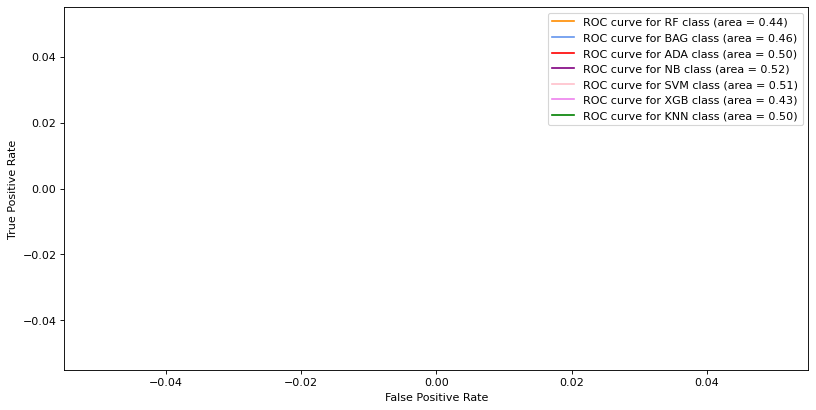

In [408]:
prob = np.concatenate((prob150, prob160, prob170, prob180, prob190, prob200, prob210), axis=1)
plot_combine_roc(val_y, prob)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\

[0.         0.01923077 0.07692308 0.11538462 0.15384615 0.19230769
 0.21153846 0.25       0.30769231 0.34615385 0.55769231 0.61538462
 0.76923077 0.80769231 0.88461538 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.05769231 0.09615385 0.17307692 0.23076923 0.34615385
 0.38461538 0.44230769 0.46153846 0.5        0.51923077 0.55769231
 0.57692308 0.61538462 0.65384615 0.73076923 0.75       0.78846154
 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] va;ues
[0.         0.03846154 0.07692308 0.15384615 0.26923077 0.38461538
 0.55769231 0.63461538 0.65384615 0.69230769 0.71153846 0.75
 0.80769231 0.84615385 0.88461538 1.        ] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.01923077 1.        ] [nan nan nan] va;ues
[0.         0.03846154 0.07692308 0.11538462 0.19230769 0.25
 0.32692308 0.36538462 0.40

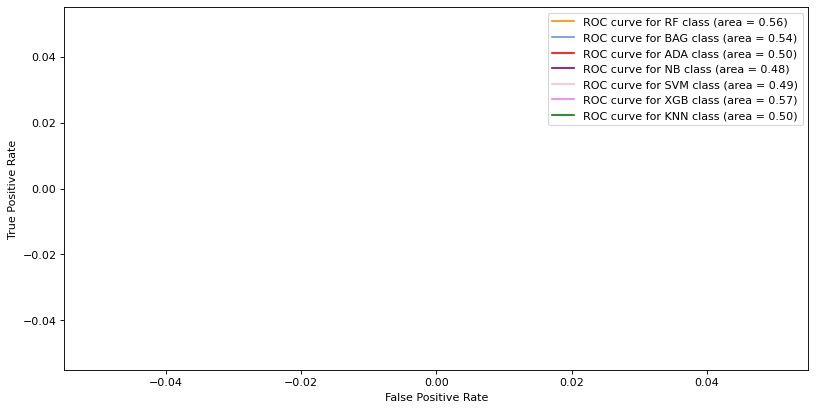

In [409]:
prob = np.concatenate((prob151, prob161, prob171, prob181, prob191, prob201, prob211), axis=1)
plot_combine_roc(val_y, prob)

## Testing

In [410]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
lbp_comp_train = combine_features([lbp_train, lbp_val], horizontal=False)
kaze_comp_train = combine_features([kaze_train, kaze_val], horizontal=False)
# sift_comp_train = combine_features([sift_train, sift_val], horizontal=False)
# surf_comp_train = combine_features([surf_train, surf_val], horizontal=False)
gabor_comp_train = combine_features([gabor_train, gabor_val], horizontal=False)
glcm_comp_train = combine_features([glcm_train, glcm_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [411]:
data_y = np.hstack([train_y, val_y])

In [413]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=30)
pca_lbp_comp_train = pca.fit_transform(lbp_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_kaze_comp_train = pca.fit_transform(kaze_comp_train)
pcas_array.append(pca)

# pca = PCA(n_components=15)
# pca_sift_comp_train = pca.fit_transform(sift_comp_train)
# pcas_array.append(pca)

# pca = PCA(n_components=5)
# pca_surf_comp_train = pca.fit_transform(surf_comp_train)
# pcas_array.append(pca)

pca = PCA(n_components=5)
pca_gabor_comp_train = pca.fit_transform(gabor_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=5)
pca_glcm_comp_train = pca.fit_transform(glcm_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [415]:
reduced_train_features=[pca_hog_comp_train,
                        pca_lbp_comp_train,
                        pca_kaze_comp_train,
#                         pca_sift_comp_train,
#                         pca_surf_comp_train,
                        pca_gabor_comp_train,
                        pca_glcm_comp_train,
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [416]:
hog_test = get_hog(test_x, name='hog_test', save=True)
lbp_test = get_lbp(test_x, name='lbp_test', save=True)
kaze_test = get_kaze(test_x, name='kaze_test', save=True)
# sift_test = get_sift(test_x, name='sift_test', save=True)
# surf_test = get_surf(test_x, name='surf_test', save=True)
gabor_test = get_gabor(test_x, name='gabor_test', save=True)
glcm_test = get_glcm(test_x, name='glcm_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/lbp_test.pkl
Feature saved with name cache/kaze_test.pkl
Feature saved with name cache/gabor_test.pkl
Feature saved with name cache/glcm_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [417]:
test_features= [hog_test,
                lbp_test,
                kaze_test,
#                 sift_test,
#                 surf_test,
                gabor_test,
                glcm_test,
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [418]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 6:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [419]:
features_comp_train.shape, features_test.shape

((257, 100), (65, 100))

In [420]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [421]:
y_hat = comp_model.predict(features_test)

In [422]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.5846153846153846
[[30 11]
 [16  8]]
0.6521739130434783 0.7317073170731707 0.6896551724137931


### CM

In [423]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)
y_hat3 = model3.predict(features_val)
y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [424]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)
cm3 = MetricTools.confusion_matrix(val_y, y_hat3, 2)
cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [425]:
print(cm1)
print(cm2)
print(cm3)
print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[28.  5.]
 [17.  2.]]
[[27.  6.]
 [16.  3.]]
[[23. 10.]
 [11.  8.]]
[[27.  6.]
 [14.  5.]]
[[30.  3.]
 [18.  1.]]
[[24.  9.]
 [13.  6.]]
[[22. 11.]
 [12.  7.]]


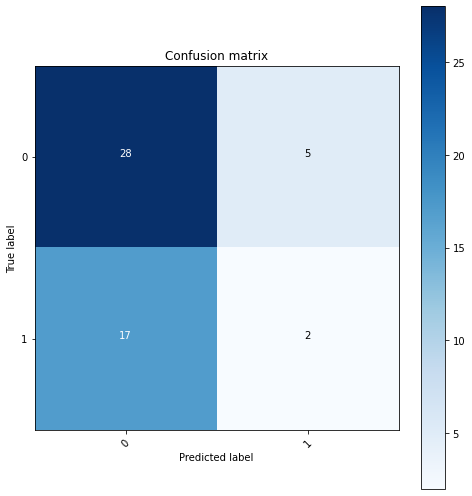

In [426]:
PlotTools.confusion_matrix(cm1, list(range(2)))

### Model Stacking:

In [471]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train, pca_lbp_train], 
                  [pca_hist_val, pca_hog_val, pca_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((205, 30), (52, 30))

In [472]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.6923076923076923
[[28  5]
 [11  8]]
Recall in 'XGB' = 0.8484848484848485
Precision in 'XGB' = 0.717948717948718
F1 Score in 'XGB' = 0.7777777777777778


In [473]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((205, 26), (52, 26))

In [474]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.6153846153846154
[[26  7]
 [13  6]]
Recall in 'XGB' = 0.7878787878787878
Precision in 'XGB' = 0.6666666666666666
F1 Score in 'XGB' = 0.7222222222222221


In [475]:
features_train3 = None
features_val3 = None
evs = []
for ft, fv in zip([pca_kaze_train], 
                  [pca_kaze_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train3 is None:
        features_train3 = ft
        features_val3 = fv
    else:
        features_train3 = combine_features([features_train3, ft])
        features_val3 = combine_features([features_val3, fv])
features_train3.shape, features_val3.shape

((205, 10), (52, 10))

In [476]:
model3 = train_model(features_train3, train_y, model_name='XGB', validation=(features_val3, val_y))
prob3 = model3.predict_proba(features_val3)

Validation Accuracy in 'XGB' = 0.5384615384615384
[[24  9]
 [15  4]]
Recall in 'XGB' = 0.7272727272727273
Precision in 'XGB' = 0.6153846153846154
F1 Score in 'XGB' = 0.6666666666666667


In [477]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)
prob3 = model3.predict_proba(features_val3)
prob4 = model4.predict_proba(features_val)
#prob5 = model5.score(features_val, )
prob6 = model6.predict_proba(features_val)

In [478]:
prob = (prob1 + prob2 + prob3 + prob4 + prob6) / 5
y_hat = np.argmax(prob, axis=1)

In [479]:
metrics.accuracy_score(val_y, y_hat)

0.5961538461538461

In [480]:
# y_hat = model.predict(features_val)

In [481]:
cm = MetricTools.confusion_matrix(val_y, y_hat, 2)

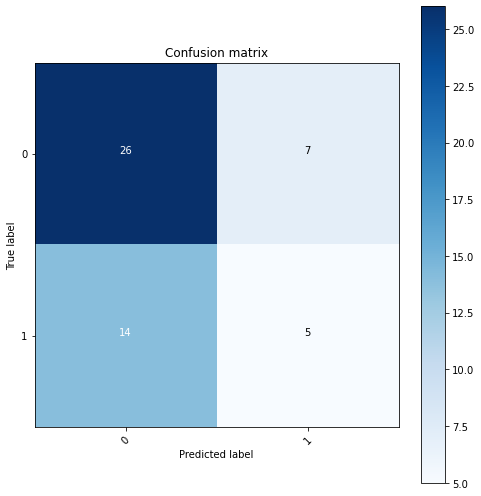

In [482]:
PlotTools.confusion_matrix(cm, list(range(2)))

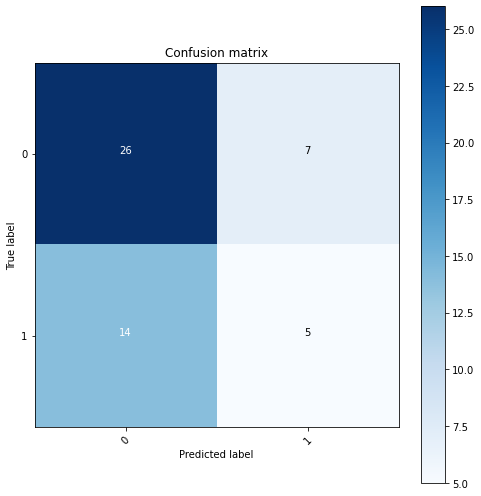

In [483]:
PlotTools.confusion_matrix(cm, list(range(2)))

In [ ]:
from keras.applications import ResNet50
resnet_model=ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model_aug=Sequential()
model_aug.add(resnet_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))

top_model.add(Dense(64, activation='relu'))
# model_aug.add(Dropout(0.2))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:171]:
    layer.trainable=False

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\toorr\appdata\local\programs\python\python37\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
model_aug.load_weights('k64 binary 25percent stride8/fine_tuned_model_resnet_64_adam_weights.h5')

model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
model_aug.evaluate(x_test, y_test, verbose=0)

In [ ]:
y_pred = model_aug.predict_classes(x_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred)